# Airbnb Rio de Janeiro - Regressão lognormal

# 1. Introdução

Esse notebook propõe aplicar um modelo de Regressão Lognormal para os [dados do Airbnb na cidade do Rio de Janeiro](https://insideairbnb.com/get-the-data/#:~:text=Rio%20de%20Janeiro%2C%20Rio%20de%20Janeiro%2C%20Brazil). 

Os dados são carregados do processo de [feature engineering](https://github.com/BPRateiro/rio-airbnb-data-analysis/blob/main/notebooks/feature_engineering.ipynb).Incluem informações detalhadas sobre a disponibilidade de listagens, características dos imóveis, interações de usuários, e preços. 

O objetivo principal é construir um modelo que preserva sua interpretabilidade.

## 1.1 Configurações e bibliotecas

In [6]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

import sys
import os
sys.path.append(os.path.abspath('..'))

from rio_airbnb.plots import PremissasGama, InterpretaCoeficientes, MapaMedianaPrecos
from rio_airbnb.modeling.train import GLMForwardSelector
from rio_airbnb.modeling.predict import load_mais_recente

## 1.2 Leitura dos dados

In [7]:
df_inicial = pd.read_parquet('../data/silver/fe_train_output.parquet')
df_inicial.drop(columns=[col for col in df_inicial.columns if df_inicial[col].nunique() == 1], inplace=True)
df_inicial.head()

,accommodates,availability_365,availability_60,bathrooms,bedrooms,beds,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,days_since_first_review,...,review_scores_value,reviews_per_month,verification_email,verification_work_email,was_reviewed,host_response_time_within_a_day,host_response_time_within_a_few_hours,host_response_time_within_an_hour,room_type_others,room_type_private_room
0,5.0,269.0,59.0,2.0,1.0,2.0,1.0,0.0,0.0,131.8,...,4.502,1.700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,176.0,56.0,2.0,2.0,0.0,6.0,0.0,0.0,173.0,...,4.500,0.690,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2.0,267.0,59.0,1.0,1.0,1.0,0.0,2.0,0.0,151.4,...,4.600,0.448,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,2.0,38.0,35.0,1.0,1.0,1.0,1.0,1.0,0.0,531.0,...,5.000,0.230,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,5.0,10.0,10.0,2.0,2.0,3.0,1.0,0.0,0.0,3631.0,...,4.740,3.040,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


# 2. Modelos de regressão gama

Abaixo, apresentamos os modelos de regressão gama que utilizamos para prever o valor do aluguel de uma casa.

## 2.1 Modelo de Baseline

Embora no EDA vimos que a distribuição mais adequada para a variável resposta `price` fosse a Gen Extreme, por razões de uma maior facilidade ao modelar e interpretar os resultados do modelo, optamos aqui por modelar nossos dados com uma distribuição Gama.

O modelo de baseline corresponde ao ajuste da média à todo e qualquer ponto da distribuição. Portanto, o modelo de baseline consiste ao intercepto, sem considerar outras variáveis explicativas.

In [8]:
# Primeiro, adicionamos uma constante para representar o intercepto
X_baseline = sm.add_constant(np.ones(df_inicial.shape[0]))  # Apenas o intercepto
y = df_inicial['price']

# Ajustar o modelo GLM com distribuição Gama e função de ligação log
gamma_model = sm.GLM(y, X_baseline, family=sm.families.Gamma(link=sm.families.links.Log()))
gamma_result = gamma_model.fit()

# Resumo do modelo ajustado
gamma_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  price   No. Observations:                24255
Model:                            GLM   Df Residuals:                    24254
Model Family:                   Gamma   Df Model:                            0
Link Function:                    Log   Scale:                         0.43221
Method:                          IRLS   Log-Likelihood:            -1.6193e+05
Date:                Tue, 24 Sep 2024   Deviance:                       9770.7
Time:                        15:04:55   Pearson chi2:                 1.05e+04
No. Iterations:                     7   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8762      0.004   1392.028      0.000       5.868       5.884
==============================================================================
"""

## 2.2 Modelo saturado

Ajustamos um modelo contendo todas as variáveis explicativas do dataset. Chegamos à um modelo com uma melhora substancial com relação à baseline. O parâmetro pseudo R² indica que o modelo inicial foi capaz de explicar aproximadamente 53% da variância dos dados.

Um passo natural para melhorar o modelo é a seleção de variáveis. Porém, precisamos primeiramente avaliar as premissas do modelo.

In [9]:
# Seleção de algumas variáveis explicativas para o modelo
X = df_inicial.drop(columns=['price'])

# Adicionar uma constante para o intercepto
X = sm.add_constant(X)

# Ajustar o modelo GLM com as variáveis explicativas selecionadas
modelo_saturado = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.Log())).fit()

# Resumo do modelo ajustado
modelo_saturado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  price   No. Observations:                24255
Model:                            GLM   Df Residuals:                    24211
Model Family:                   Gamma   Df Model:                           43
Link Function:                    Log   Scale:                         0.25149
Method:                          IRLS   Log-Likelihood:            -1.5395e+05
Date:                Tue, 24 Sep 2024   Deviance:                       5154.1
Time:                        15:05:01   Pearson chi2:                 6.09e+03
No. Iterations:                    23   Pseudo R-squ. (CS):             0.5308
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                          -65.4302      2.291    -28.561      0.000     -69.920     -60.940
accommodates                                     0.0475      0.002     19.274      0.000       0.043       0.052
availability_365                                 0.0004   3.32e-05     11.206      0.000       0.000       0.000
availability_60                                  0.0009      0.000      4.746      0.000       0.001       0.001
bathrooms                                        0.1057      0.006     18.275      0.000       0.094       0.117
bedrooms                                         0.1641      0.005     31.183      0.000       0.154       0.174
beds                                            -0.0192      0.002     -7.795      0.000      -0.024      -0.014
calculated_host_listings_count_entire_homes      0.0001      0.000      0.569      0.569      -0.000       0.000
calculated_host_listings_count_private_rooms     0.0012      0.002      0.609      0.543      -0.003       0.005
calculated_host_listings_count_shared_rooms     -0.0283      0.004     -6.912      0.000      -0.036      -0.020
days_since_first_review                      -4.814e-05   5.21e-06     -9.239      0.000   -5.84e-05   -3.79e-05
days_since_host_active                        2.101e-05   3.13e-06      6.712      0.000    1.49e-05    2.71e-05
days_since_last_review                           0.0002   1.05e-05     19.442      0.000       0.000       0.000
description_length                           -5.651e-06   2.16e-05     -0.261      0.794   -4.81e-05    3.68e-05
host_about_length                            -5.064e-05   1.15e-05     -4.417      0.000   -7.31e-05   -2.82e-05
host_acceptance_rate                             0.0362      0.015      2.384      0.017       0.006       0.066
host_identity_verified                          -0.0010      0.009     -0.111      0.912      -0.019       0.017
host_is_superhost                                0.0315      0.008      3.822      0.000       0.015       0.048
host_listings_count                              0.0002   4.53e-05      5.412      0.000       0.000       0.000
host_responded                                  -0.3694      0.016    -23.141      0.000      -0.401      -0.338
instant_bookable                                 0.0450      0.009      5.271      0.000       0.028       0.062
latitude                                        -4.7681      0.104    -45.775      0.000      -4.972      -4.564
longitude                                        0.9097      0.038     24.160      0.000       0.836       0.984
maximum_nights                               -3.832e-05   8.16e-06     -4.695      0.000   -5.43e-05   -2.23e-05
minimum_nights                  

# 2.3 Avaliação das premissas

Aplicando um teste de Kolmogorov-Smirnov (KS) aos resíduos, podemos observar:
- `KS Statistic (0.03)`: mede a diferença máxima entre a distribuição dos resíduos e a distribuição gama ajustada. O valor próximo de 0 indica que as distribuições são semelhantes.
- `p-value (1.17e-16):`  um valor baixo de p-value sugere que há uma diferença estatisticamente significativa entre os resíduos e a distribuição gama. Isso implica que os resíduos provavelmente não seguem a distribuição gama ajustada.

Apesar do valor da estatística KS ser baixo, o p-valor sugere que temos evidência que a hipótese nula deve ser rejeitada, ou seja, os resíduos não seguem uma distribuição gama ajustada.

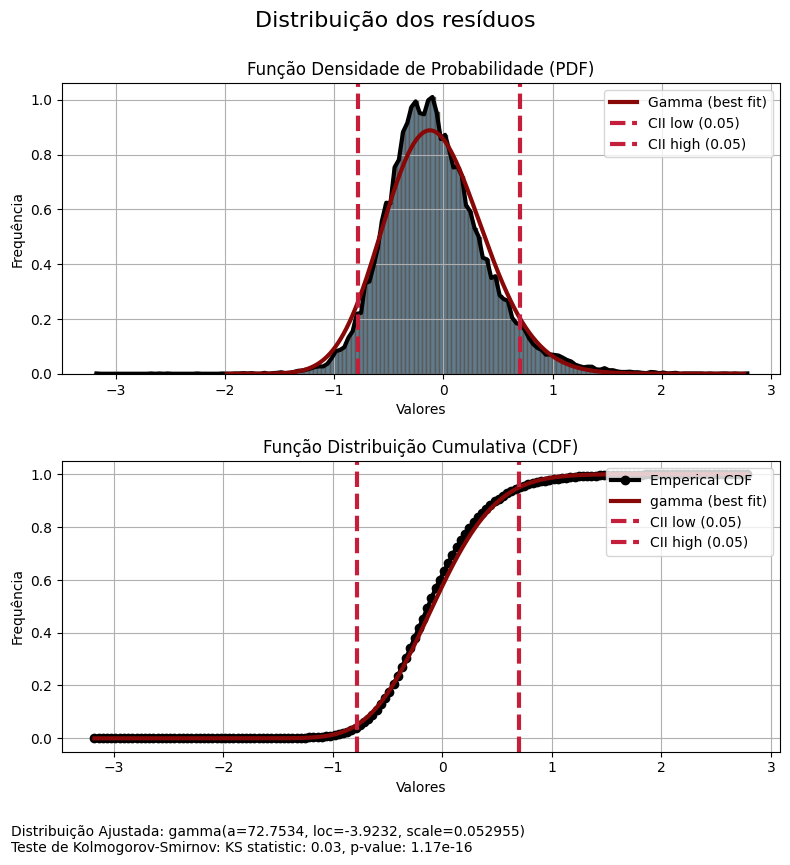

In [10]:
premissas = PremissasGama(modelo_saturado)
ks_stat, p_value = premissas.distribuicao_residuos_gama()

# 3. Forward Selection

Uma vez que a seleção de variáveis não é adequada para o modelo saturado, pois esse não se ajusta adequadamente à distribuição selecionada, optamos por um método de seleção automática de variáveis, o [forward selection](https://planspace.org/20150423-forward_selection_with_statsmodels/).

In [12]:
selector = GLMForwardSelector(df_inicial, response='price', family=sm.families.Gamma(link=sm.families.links.Log()))
modelo_otimizado = selector.select()
summary = modelo_otimizado.summary()
summary

2024-09-24 15:22:36.727 | INFO     | rio_airbnb.modeling.train:_save_model:61 - Modelo salvo em: C:\Bruno\Projects\rio-airbnb-data-analysis\models\glm_model_20240924_152236.pkl


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  price   No. Observations:                24255
Model:                            GLM   Df Residuals:                    24218
Model Family:                   Gamma   Df Model:                           36
Link Function:                    Log   Scale:                         0.25138
Method:                          IRLS   Log-Likelihood:            -1.5395e+05
Date:                Tue, 24 Sep 2024   Deviance:                       5154.8
Time:                        15:22:36   Pearson chi2:                 6.09e+03
No. Iterations:                    23   Pseudo R-squ. (CS):             0.5309
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                     -65.5404      2.280    -28.742      0.000     -70.010     -61.071
bedrooms                                        0.1641      0.005     31.214      0.000       0.154       0.174
host_responded                                 -0.3634      0.011    -31.730      0.000      -0.386      -0.341
latitude                                       -4.7683      0.104    -45.993      0.000      -4.971      -4.565
room_type_private_room                         -0.3127      0.009    -34.599      0.000      -0.330      -0.295
reviews_per_month                              -0.1000      0.004    -25.369      0.000      -0.108      -0.092
room_type_others                               -0.5733      0.030    -19.028      0.000      -0.632      -0.514
was_reviewed                                   -0.2251      0.009    -24.111      0.000      -0.243      -0.207
longitude                                       0.9072      0.038     24.152      0.000       0.834       0.981
bathrooms                                       0.1057      0.006     18.310      0.000       0.094       0.117
days_since_last_review                          0.0002   1.04e-05     19.511      0.000       0.000       0.000
accommodates                                    0.0475      0.002     19.306      0.000       0.043       0.052
num_amenities                                   0.0039      0.000     14.984      0.000       0.003       0.004
availability_365                                0.0004    3.3e-05     11.235      0.000       0.000       0.000
review_scores_location                          0.1693      0.015     11.372      0.000       0.140       0.198
days_since_first_review                     -4.889e-05   5.15e-06     -9.501      0.000    -5.9e-05   -3.88e-05
calculated_host_listings_count_shared_rooms    -0.0283      0.004     -6.933      0.000      -0.036      -0.020
review_scores_cleanliness                       0.0784      0.014      5.511      0.000       0.051       0.106
review_scores_value                            -0.1998      0.015    -12.961      0.000      -0.230      -0.170
review_scores_rating                            0.1526      0.022      7.008      0.000       0.110       0.195
verification_work_email                         0.0675      0.013      5.028      0.000       0.041       0.094
minimum_nights                                 -0.0024      0.000     -7.834      0.000      -0.003      -0.002
beds                                           -0.0193      0.002     -7.830      0.000      -0.024      -0.014
days_since_host_active                       2.132e-05   3.08e-06      6.919      0.000    1.53e-05    2.74e-05
instant_bookable                                0.0453     

# 4. Interpretação dos resultados

2024-09-24 15:22:37.823 | INFO     | rio_airbnb.modeling.predict:load_mais_recente:28 - Modelo mais recente carregado: C:\Bruno\Projects\rio-airbnb-data-analysis\models\glm_model_20240924_152236.pkl


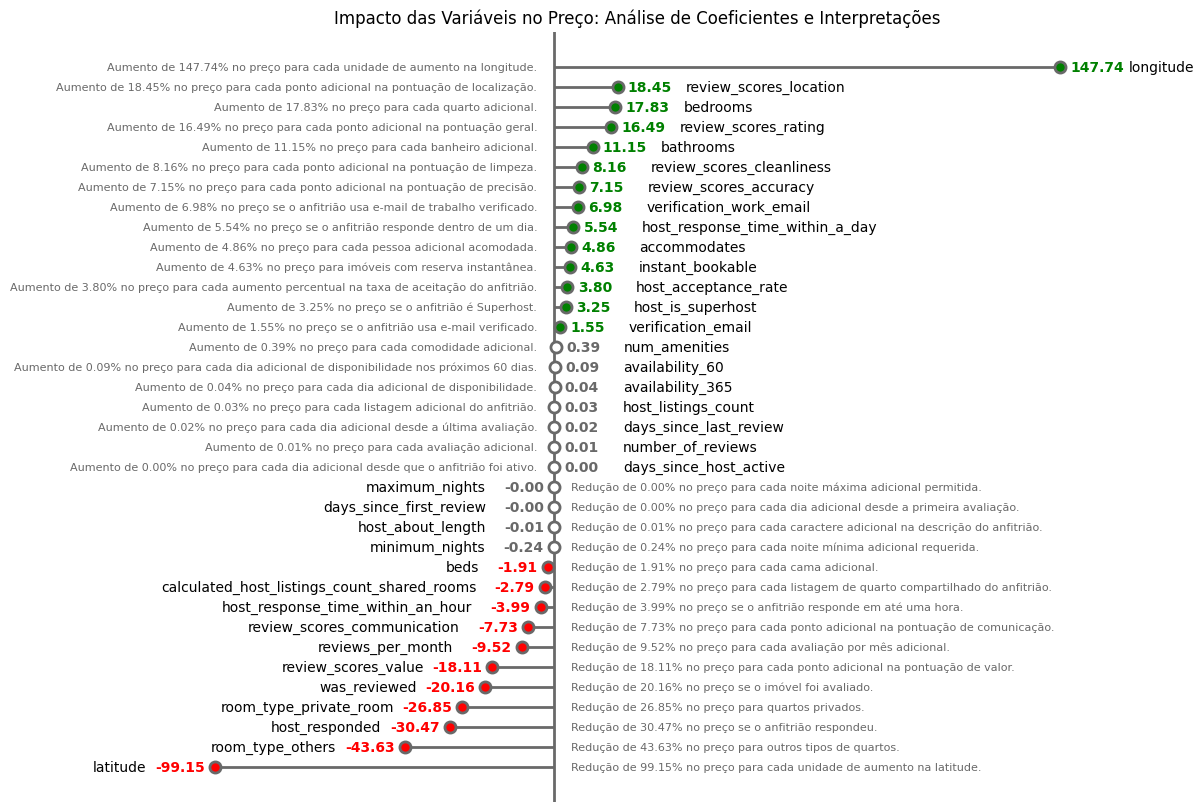

In [13]:
modelo = load_mais_recente()
interpreta_coef = InterpretaCoeficientes(modelo.summary())
interpreta_coef.plotar_coeficientes()

# 5. Conclusão

A análise do modelo revela que a localização geográfica (latitude e longitude) tem um impacto significativo no preço. Tipos de acomodação que não são apartamentos ou casas inteiras são consideravelmente mais baratas. A responsividade do anfitrião e o fato de a propriedade ter sido avaliada estão associados a preços mais baixos, enquanto características como o número de quartos, banheiros, e a pontuação de localização contribuem para aumentos de preço.